# Searching for TSP solutions
The notebook includes code to load a datafile of 115,475 cities in the US and run a hill-climbing algorithm in attempt to find a short tour of all the cities. 

In [1]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
import math
import time

### Load and plot data

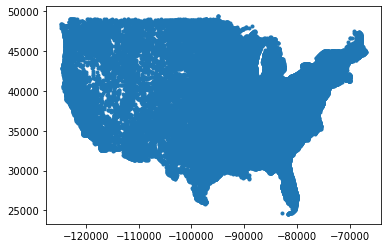

In [2]:
with open("cities.csv") as datafile:
    data = np.loadtxt(datafile, delimiter=" ")[:,1:] # chop of city indices

N = len(data)
    
CITIES = np.zeros((N,2))
CITIES[:,0] = -data[:,1]
CITIES[:,1] = data[:,0]
    
plt.plot(CITIES[:,0],CITIES[:,1],'.');

### Utility functions for calculating tour length, local tour changes, and checking local optimality
Also prints the length of the tour specified by visiting the cities in the order they appear in the data file.

In [3]:
# calculates the distance between city_i and city_j
def dist(city_i,city_j):
    return math.sqrt((city_i[0]-city_j[0])**2 + (city_i[1]-city_j[1])**2)

# assuming order is a permutation of the integers {0,...,N-1}, calculate associated tour length
def tour_length(cities,tour):
    n = len(cities)
    length = 0
    for i in range(1,n): # add dist(i-1,i)
        length += dist(cities[tour[i-1],:],cities[tour[i],:])
    return length + dist(cities[tour[0],:],cities[tour[n-1],:])

# swaps two values in arr, based on the indices specified by pair
def swap(arr,pair):
    o_i = arr[pair[0]]
    arr[pair[0]]=arr[pair[1]]
    arr[pair[1]]=o_i

# checks that no single swap improves the given tour
def is_local_opt(cities,tour):
    curr = tour_length(cities,tour)
    for i in range(1,len(cities)):
        for j in range(1,i):
            p=(i,j)
            swap(tour,p)
            if tour_length(cities,tour)<curr:
                return False
            swap(tour,p)
    return True

# print the distance if visiting cities in the order 0,2,...,N-1,0
print("Length of in-order tour of",len(CITIES),"cities:",tour_length(CITIES,np.array(range(len(CITIES)))))
print("Is locally optimal?",is_local_opt(CITIES,np.array(range(len(CITIES)))))


Length of in-order tour of 115475 cities: 213920969.00611648
Is locally optimal? False


### Identify all local optima
Recursively enumerate all tours, checking whether each is a local optimum and printing the tour and its length if so.

In [4]:
# print all permutations starting with prefix
def check_all_tours(cities,prefix,nums_left):
    if len(nums_left)==0:
        if is_local_opt(cities,prefix):
            print(prefix,tour_length(cities,prefix))
        return
    for i in range(len(nums_left)):
        check_all_tours(cities,np.concatenate((prefix,np.array([nums_left[i]]))),np.delete(nums_left,i))

n_small = 9
check_all_tours(CITIES[:n_small,:],np.array([0]),np.array(range(1,n_small))) 


[0 1 2 3 6 7 4 5 8] 6751.513992301445
[0 1 6 7 4 5 8 3 2] 9528.587237263353
[0 1 8 5 4 6 2 3 7] 8258.55196189125
[0 1 8 5 4 7 6 2 3] 8136.00305741148
[0 2 3 8 5 4 7 6 1] 9528.587237263355
[0 3 2 6 7 1 5 4 8] 7951.969192866592
[0 3 2 6 7 4 5 8 1] 8136.003057411479
[0 5 4 7 6 3 2 1 8] 7516.6136256671225
[0 7 3 2 6 4 5 8 1] 8258.55196189125
[0 7 6 3 2 1 5 4 8] 7437.120531210008
[0 8 1 2 3 6 7 4 5] 7516.613625667123
[0 8 4 5 1 2 3 6 7] 7437.120531210009
[0 8 4 5 1 7 6 2 3] 7951.969192866592
[0 8 5 4 7 6 3 2 1] 6751.513992301445


### Hill-climbing algorithm
Given a list of cities and an initial tour, iteratively search for single swaps that improve the current tour. For each successive improvement, try up to n choose 2 random swaps to see if that yields an additional improvement. Uniformly random exploration of neighbors means this iterative improvement is not guaranteed to terminate on a local optimum. 

In [5]:
def random_pair(n):
    i = j = np.random.randint(1,n)
    while i==j:
        j = np.random.randint(1,n)
    return i,j

def hill_climb(cities,tour):
    n = len(cities)
    found_better = True
    while found_better:
        found_better = False
        len_curr = tour_length(cities,tour)
        #print(len_curr)
        for i in range((int)(n*(n-1)/2)): # try as many random swaps as swap options
            p = random_pair(n)
            swap(tour,p)
            len_new = tour_length(cities,tour)
            if len_new < len_curr: # if swap was an improvement, keep it
                found_better = True
                break 
            else: # if swap wasn't an improvement, revert and look for a different one
                swap(tour,p)
    return tour

### Hill-climbing experiments
Run the hill-climbing algorithm for several trials on random starting tours, printing out start length, final length, and whether the output was a local min.

In [6]:
n_small = 9 #len(CITIES) #9
cities = CITIES[:n_small,:]

n_trials = 5
np.random.seed(0)

for i in range(n_trials):
    tour = np.array(range(n_small))
    np.random.shuffle(tour[1:n_small]) # random start
    print(tour_length(cities,tour)) # print length of random start
    hill_climb(cities,tour)
    print(tour_length(cities,tour)) # print length of hill-climbing solution
    print(is_local_opt(cities,tour),"\n") # report whether it was a local min


11038.131468911171
6789.169540091053
False 

13098.580512722769
9528.587237263355
True 

10066.623794184048
8346.22843233142
False 

9741.895639318409
7388.911558437798
False 

12950.018471500658
6751.513992301445
True 



### Simulated annealing algorithm
Given a list of cities and a max number of iterations, iteratively consider single swaps, accepting all improving swaps and probabilistically accepting deteriorating moves with decreasing probability as time goes on. Acceptance probability and annealing schedule should be modified for the problem; currently temperature decreases with time and is scaled by a sample standard deviation measured at the beginning of the annealing process, and probability of accepting of swaps decreases with how much they increase length and with temperature.

6751.513992301445
True
-86118.3061


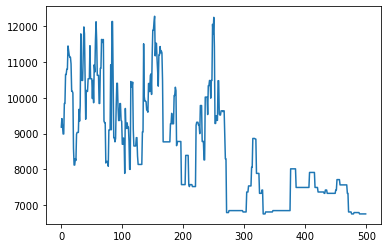

In [7]:
def p_accept(energy1,energy2,temp):
    if energy2<energy1: return 1 # automatically accept better neighbor
    return math.exp(-(energy2-energy1)/temp) # accept w.p. decreasing with inferiority of neighbor

# sets a temperature based on the time left [0,1)
def temperature(time_left,scale):
    return time_left*scale+.0000001 #time_left*math.sqrt(scale)+.0000001

# calculates the sample 
def get_ssd(cities):
    n = len(cities)
    perm = np.array(range(n))
    var = 0
    for i in range(100):
        np.random.shuffle(perm[1:n])
        len_orig = tour_length(cities,perm)
        swap(perm,random_pair(n))
        var += (tour_length(cities,perm)-len_orig)**2
    return math.sqrt(var/100)
    
def anneal(cities,k_max,vals):
    s = get_ssd(cities)
    n = len(cities)
    tour = np.array(range(n))
    np.random.shuffle(tour[1:n])
    for k in range(k_max):
        temp = temperature(1-(k+1)/k_max,s)
        len_curr = tour_length(cities,tour)
        p = random_pair(n)
        swap(tour,p)
        len_new = tour_length(cities,tour)
        if p_accept(len_curr,len_new,temp)<np.random.uniform():
            swap(tour,p)
        vals[k] = tour_length(cities,tour)
    return tour


n_small = 9 
cities = CITIES[:n_small,:]
k_max = 500#1000,2000,5000
np.random.seed(0)
vals = np.zeros(k_max)
sa_tour = anneal(cities,k_max,vals)
plt.plot(np.array(range(k_max)),vals);
print(tour_length(cities,sa_tour))
print(is_local_opt(cities,sa_tour))

print(CITIES[0,0])

In [8]:
import random
import copy
import os
import csv

try:
    from tkinter import *
    from tkinter.ttk import *
except Exception as e:
    print("[ERROR]: {0}".format(e))
    from Tkinter import *

############################### Variables / Params ###############################
    
list_of_cities = []
mut_prob = 0.4
num_gens = 100
population_size = 100
tournament_size = 7
elitism = True
csv_cities = False
csv_name = 'cities.csv'

################################# City Class ##################################

class City(object):
    
    def __init__(self, name, x, y, distance_to=None):

        self.name = name
        self.x = self.graph_x = x
        self.y = self.graph_y = y
        list_of_cities.append(self)
        self.distance_to = {self.name:0.0}
        
        if distance_to:
            self.distance_to = distance_to
            
            
    def calculate_distances(self):
        for city in list_of_cities:
            tmp_dist = self.point_dist(self.x, self.y, city.x, city.y)
            self.distance_to[city.name] = tmp_dist
            
            
    def point_dist(self, x1,y1,x2,y2):
        return ((x1-x2)**2 + (y1-y2)**2)**(0.5)

################################# Route Class #################################
    
class Route(object):

    def __init__(self):
        self.route = sorted(list_of_cities, key=lambda *args: random.random())
        self.recalc_rt_len()
        

    def recalc_rt_len(self):
        self.length = 0.0

        for city in self.route:
            next_city = self.route[self.route.index(city)-len(self.route)+1]
            dist_to_next = city.distance_to[next_city.name]
            self.length += dist_to_next
            
            
    def print_cities(self, print_route=False):

        cities_str = ''
        for city in self.route:
            cities_str += city.name + ', '
            
        cities_str = cities_str[:-1]
        if print_route:
            print('' + cities_str)
            
            
    def print_coords(self):
        
        cities_str = '|'
        for city in self.route:
            cities_str += str(city.x) + ', ' + str(city.y) + '|'
            
        print(cities_str)
        
        
    def is_valid_route(self):
        for city in list_of_cities:
            if self.count_mult(self.route,lambda c: c.name == city.name) > 1:
            
                return False
            
        return True
    
    
    def count_mult(self, seq, pred):
        return sum(1 for v in seq if pred(v))
    
########################### Population of Routes (Class) ##########################
    
class route_population(object):

    def __init__(self, size, initialize):
        self.rt_pop = []
        self.size = size
        
        if initialize:
            for x in range(0,size):
                new_rt = Route()
                self.rt_pop.append(new_rt)
                
            self.get_fittest()
            
            
    def get_fittest(self):

        sorted_list = sorted(self.rt_pop, key=lambda x: x.length, reverse=False)
        self.fittest = sorted_list[0]
        return self.fittest

############################### Genetic Alg Class ################################
    
class GA(object):

    def crossover(self, parent1, parent2):
        
        child_rt = Route()

        for x in range(0,len(child_rt.route)):
            child_rt.route[x] = None
            
        start_pos = random.randint(0,len(parent1.route))
        end_pos = random.randint(0,len(parent1.route))

        if start_pos < end_pos:
            for x in range(start_pos,end_pos):
                child_rt.route[x] = parent1.route[x] 
                
        elif start_pos > end_pos:
            for i in range(end_pos,start_pos):
                child_rt.route[i] = parent1.route[i]

        for i in range(len(parent2.route)):
            if not parent2.route[i] in child_rt.route:
                for x in range(len(child_rt.route)):
                    if child_rt.route[x] == None:
                        child_rt.route[x] = parent2.route[i]
                        
                        break

        child_rt.recalc_rt_len()
        
        return child_rt

    
    def mutate(self, mut_route):
 
        if random.random() < mut_prob:
            pos_1 = random.randint(0,len(mut_route.route)-1)
            pos_2 = random.randint(0,len(mut_route.route)-1)

            if pos_1 == pos_2:
                return mut_route
            
            city_1 = mut_route.route[pos_1]
            city_2 = mut_route.route[pos_2]

            mut_route.route[pos_2] = city_1
            mut_route.route[pos_1] = city_2

        mut_route.recalc_rt_len()

        return mut_route
  

    def tournament_select(self, population):
        
        tournament_pop = route_population(size=tournament_size, initialize=False)
        
        for i in range(tournament_size-1):
            tournament_pop.rt_pop.append(random.choice(population.rt_pop))
        
        return tournament_pop.get_fittest()
    

    def evolve_pop(self, init_pop):
    
        descendant_pop = route_population(size=init_pop.size, initialize=True)
        elitismOffset = 0

        if elitism:
            descendant_pop.rt_pop[0] = init_pop.fittest
            elitismOffset = 1
            
        for x in range(elitismOffset, descendant_pop.size):

            tournament_parent1 = self.tournament_select(init_pop)
            tournament_parent2 = self.tournament_select(init_pop)
            tournament_child = self.crossover(tournament_parent1, tournament_parent2)
            descendant_pop.rt_pop[x] = tournament_child

        for route in descendant_pop.rt_pop:
            if random.random() < 0.3:
                self.mutate(route)

        descendant_pop.get_fittest()

        return descendant_pop
    
############################### Graphing Utility ###############################
                                  
class App(object):

    def __init__(self, n_generations, pop_size, graph=False):
                                  
        if csv_cities:
            self.read_csv()

            print("read csv")
        self.n_generations = n_generations
        self.pop_size = pop_size

        if graph:                    
            self.set_coords()
            self.window = Tk()
            self.window.wm_title("Generation 0")

            self.canvas_current = Canvas(self.window, height=300, width=300)
            self.canvas_best = Canvas(self.window, height=300, width=300)

            self.canvas_current_title = Label(self.window, text="Curr Gen Best:")
            self.canvas_best_title = Label(self.window, text="Red: Curr Gen Best Route, Green: Overall Best Route")

            self.stat_tk_txt = StringVar()
            self.status_label = Label(self.window, textvariable=self.stat_tk_txt, relief=SUNKEN, anchor=W)

            for city in list_of_cities:
                self.canvas_current.create_oval(city.graph_x-2, city.graph_y-2, city.graph_x + 2, city.graph_y + 2, fill='blue')
                self.canvas_best.create_oval(city.graph_x-2, city.graph_y-2, city.graph_x + 2, city.graph_y + 2, fill='blue')

            
            self.canvas_current.pack()
            self.canvas_best_title.pack()
            self.canvas_best.pack()
            self.status_label.pack(side=BOTTOM, fill=X)
            self.window_loop(graph)
                                  
        else:
            self.GA_loop(n_generations, pop_size, graph=graph)                         

                                  
    def set_coords(self):
      
        min_x = 100000
        max_x = -100000
        min_y = 100000
        max_y = -100000

        # Find max / min
        for city in list_of_cities:

            if city.x < min_x:
                min_x = city.x
            if city.x > max_x:
                max_x = city.x

            if city.y < min_y:
                min_y = city.y
            if city.y > max_y:
                max_y = city.y
                                  
        for city in list_of_cities:
            city.graph_x = (city.graph_x + (-1*min_x))
            city.graph_y = (city.graph_y + (-1*min_y))

        min_x = 100000
        max_x = -100000
        min_y = 100000
        max_y = -100000

        # Find max / min
        for city in list_of_cities:

            if city.graph_x < min_x:
                min_x = city.graph_x
            if city.graph_x > max_x:
                max_x = city.graph_x

            if city.graph_y < min_y:
                min_y = city.graph_y
            if city.graph_y > max_y:
                max_y = city.graph_y

       
        if max_x > max_y:
            stretch = 300 / max_x
        else:
            stretch = 300 / max_y

        for city in list_of_cities:
            city.graph_x *= stretch
            city.graph_y = 300 - (city.graph_y * stretch)
                                  

    def update_canvas(self, the_canvas, the_route, color):

        # Clear path keyword
        the_canvas.delete('path')

        for i in range(len(the_route.route)):
            next_i = i-len(the_route.route)+1

            # Connect vertices in graph display
            the_canvas.create_line(the_route.route[i].graph_x,
                                the_route.route[i].graph_y,
                                the_route.route[next_i].graph_x,
                                the_route.route[next_i].graph_y,
                                tags=("path"),
                                fill=color)

            # Update 
            the_canvas.pack()
            the_canvas.update_idletasks()
                                  
                                  
    def read_csv(self):
        with open(csv_name, 'rt') as f:
            reader = csv.reader(f)
            for row in reader:
                new_city = City(row[0], float(row[1]), float(row[2]))
                                  
                                  
    def GA_loop(self, n_generations, pop_size, graph=False):

        # Init population
        the_population = route_population(pop_size, True)
        initial_length = the_population.fittest.length
        best_route = Route()

        if graph:
            self.update_canvas(self.canvas_current, the_population.fittest, 'red')
            self.update_canvas(self.canvas_best, best_route, 'green')

        for x in range(1, n_generations):
            if x % 8 == 0 and graph:
                self.update_canvas(self.canvas_current, the_population.fittest, 'red')

            the_population = GA().evolve_pop(the_population)

            if the_population.fittest.length < best_route.length:
                best_route = copy.deepcopy(the_population.fittest)
                                  
                if graph:
                    self.update_canvas(self.canvas_best,best_route,'green')
                    self.stat_tk_txt.set('Initial Route Distance {0:.2f} Best Route Distance = {1:.2f}'.format(initial_length, best_route.length))
                    self.status_label.pack()
                    self.status_label.update_idletasks()
                                  
            # Print iteration results for comparison
            self.clear_term()
            print('Generation {0} of {1}'.format(x, n_generations))
            print(' ')
            print('Overall Best Route has Distance {0:.2f}'.format(best_route.length))
            print('With Path:')
            best_route.print_cities(True)
            print(' ')
            print('Current Best Route has Distance {0:.2f}'.format(the_population.fittest.length))
            print('With Path:')
            the_population.fittest.print_cities(True)
            print(' ')

            if graph:
                self.window.wm_title("Generation {0}".format(x))
                
        if graph:
            self.window.wm_title("Generation {0}".format(n_generations))
            self.update_canvas(self.canvas_best, best_route, 'green')
            
        # Final out
        self.clear_term()
        print(' ')
        print('Final Best Route Distance:   {0:.2f}'.format(best_route.length))
        print('Final Best Path, City-to-City:')
        best_route.print_cities(print_route=True)                               
                                  
                                  
    def window_loop(self, graph):
        self.window.after(0,self.GA_loop(self.n_generations, self.pop_size, graph))
        self.window.mainloop()
                                  
                                  
    def clear_term(self):
        os.system('cls' if os.name == 'nt' else 'clear')

################################ Testing Algorithm ################################

def test_func():
                                  
    ''''print("Running algorithm with list of 20 random cities, with randomly generated X and Y coordinates ranging from 1-200")
    a = City('City 1', random.randint(1,200), random.randint(1,200))
    b = City('City 2', random.randint(1,200), random.randint(1,200))
    c = City('City 3', random.randint(1,200), random.randint(1,200))
    d = City('City 4', random.randint(1,200), random.randint(1,200))
    e = City('City 5', random.randint(1,200), random.randint(1,200))
    f = City('City 6', random.randint(1,200), random.randint(1,200))
    g = City('City 7', random.randint(1,200), random.randint(1,200))
    h = City('City 8', random.randint(1,200), random.randint(1,200))
    i = City('City 9', random.randint(1,200), random.randint(1,200))
    j = City('City 10', random.randint(1,200), random.randint(1,200))
    k = City('City 11', random.randint(1,200), random.randint(1,200))
    l = City('City 12', random.randint(1,200), random.randint(1,200))
    m = City('City 13', random.randint(1,200), random.randint(1,200))
    n = City('City 14', random.randint(1,200), random.randint(1,200))
    o = City('City 15', random.randint(1,200), random.randint(1,200))
    p = City('City 16', random.randint(1,200), random.randint(1,200))
    q = City('City 17', random.randint(1,200), random.randint(1,200))
    r = City('City 18', random.randint(1,200), random.randint(1,200))
    s = City('City 19', random.randint(1,200), random.randint(1,200))
    t = City('City 20', random.randint(1,200), random.randint(1,200))'''
    
    print(CITIES[0])
    
    num_cities = 100 #20#30#50#100#250#500#1000
    
    
    for i in range(num_cities):
        #rand_num = random.randint(1,10000)
        rand_num = random.randint(1,200)
        city = City(str(i), CITIES[rand_num,0], CITIES[rand_num,1])
        #city = City(str(i), CITIES[i,0], CITIES[i,1])

    for city in list_of_cities:
        city.calculate_distances()
        
    app = App(n_generations=num_gens, pop_size=population_size, graph=True)
                                  
                                  
if __name__ == '__main__':
    test_func()

[-86118.3061  33613.1588]
Generation 1 of 100
 
Overall Best Route has Distance 175483.87
With Path:
52, 6, 16, 92, 3, 82, 76, 23, 69, 60, 37, 29, 41, 78, 34, 68, 22, 90, 8, 9, 77, 10, 7, 32, 42, 58, 33, 46, 71, 36, 18, 50, 70, 38, 66, 11, 40, 72, 30, 53, 67, 54, 24, 13, 59, 17, 55, 31, 1, 15, 74, 83, 19, 79, 93, 94, 61, 95, 75, 88, 47, 2, 97, 73, 5, 57, 65, 20, 80, 89, 91, 86, 48, 12, 64, 49, 14, 28, 4, 62, 35, 39, 81, 44, 85, 56, 84, 96, 63, 0, 25, 87, 43, 98, 99, 45, 21, 27, 51, 26,
 
Current Best Route has Distance 175483.87
With Path:
52, 6, 16, 92, 3, 82, 76, 23, 69, 60, 37, 29, 41, 78, 34, 68, 22, 90, 8, 9, 77, 10, 7, 32, 42, 58, 33, 46, 71, 36, 18, 50, 70, 38, 66, 11, 40, 72, 30, 53, 67, 54, 24, 13, 59, 17, 55, 31, 1, 15, 74, 83, 19, 79, 93, 94, 61, 95, 75, 88, 47, 2, 97, 73, 5, 57, 65, 20, 80, 89, 91, 86, 48, 12, 64, 49, 14, 28, 4, 62, 35, 39, 81, 44, 85, 56, 84, 96, 63, 0, 25, 87, 43, 98, 99, 45, 21, 27, 51, 26,
 
Generation 2 of 100
 
Overall Best Route has Distance 161972.7